In [1]:
import tensorflow as tf
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [2]:
#prepare the data
import pandas as pd
import numpy as np

data = pd.read_csv('data/trainingdata300.csv')
data = data.fillna(method="ffill")
data.tail(10)

,satzId,Wort,Attribut
4945007,55339,start,O
4945008,55339,Load,O
4945009,55339,amount,O
4945010,55339,setting,O
4945011,55339,SAFETY,O
4945012,55339,AND,O
4945013,55339,MAINTENANCE,O
4945014,55339,Lockable,O
4945015,55339,control,O
4945016,55339,panel,O


In [3]:
words = list(set(data["Wort"].values))
n_words = len(words); n_words

82108

In [4]:
tags = list(set(data["Attribut"].values))
n_tags = len(tags); n_tags

7

In [5]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Wort"].values.tolist(),
                                                           s["Attribut"].values.tolist())]
        self.grouped = self.data.groupby("satzId").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    #ToDo: get_next funktioniert nicht richtig, da manche satzIds nicht vorhanden sind
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None


In [6]:
getter = SentenceGetter(data)

In [7]:
sent = getter.get_next()
print(sent)

None


In [8]:
sentences = getter.sentences

In [9]:
# prepare the tokens

max_len = 75
max_len_char = 10

In [10]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [11]:
#Beispiele
print(word2idx["Broan"])
print(tag2idx["B-Brand"])

19155
2


In [12]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

In [13]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [14]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

1838


In [15]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [16]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [17]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [18]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2021)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2021)

In [21]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [22]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

In [23]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 75, 10, 10)   18400       input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 20)       1642200     input_1[0][0]                    
______________________________________________________________________________________________

In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005, #default: 0.0001 -> wenn höher, stoppt es eher, bei 0.00001:
    patience=5,
    verbose=1, 
    mode='min',
    restore_best_weights=True)
history = model.fit([X_word_tr,
                    np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=64, 
                    epochs=50, 
                    validation_split=0.1, 
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
161/493 [========>.....................] - ETA: 54s - loss: 0.8421 - acc: 0.8999

In [ ]:
hist = pd.DataFrame(history.history)

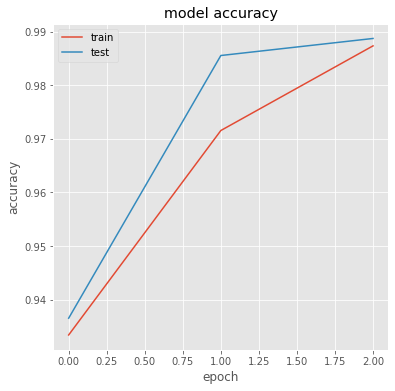

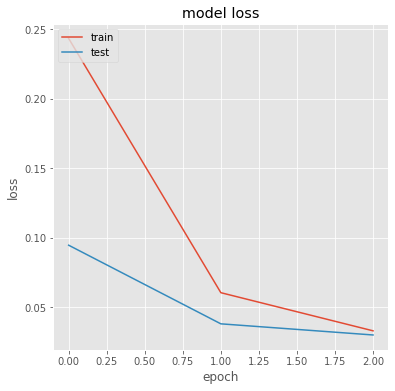

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(6,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])


In [ ]:
i = 2011
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0 and (idx2tag[t] == 'O' or idx2tag[pred] == 'O'):
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
THE            : B-Brand B-Brand
BAKER          : E-Brand B-Brand
Electric       : O     O
Oven           : O     O
ESM-100L       : B-Modelnumber B-Modelnumber
(              : O     O
100L           : O     O
)              : O     O
c              : O     O
/              : O     O
w              : O     O
Convection     : O     O
Rotisserie     : O     O
2-Pcs          : O     O
Baking         : O     O
Tray           : O     O
Ketuhar        : O     O
Besar          : O     O
*              : O     O
*              : O     O
IMPORTANT      : O     O
*              : O     O
*              : O     O
-              : O     O
EXCLUDE        : O     O
the            : O     O
roasted        : O     O
chickens       : O     O
displayed      : O     O
in             : O     O
the            : O     O
oven           : O     O
FEATURES       : O     O
=              : O     O
=              : O     O
=              : O     O
=              : O     O
=         

In [ ]:
cClass = 0
wClass = 0
cO = 0
results = []
for i in range(len(X_word_te)):
    p = np.argmax(y_pred[i], axis=-1)
    predDict = {'B-Brand': '',
                'I-Brand': '',
                'E-Brand': '',
                'B-Modelnumber': '',
                'I-Modelnumber': '',
                'E-Modelnumber': ''}
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            if idx2tag[t] == idx2tag[pred] and idx2tag[t] != 'O' and idx2tag[pred != '0']:
                cClass += 1
                predDict.update({idx2tag[pred]: idx2word[w]})
            elif idx2tag[t] == 'O' and idx2tag[pred] == 'O':
                cO += 1
            else: wClass += 1
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
    results.append(predDict)
print(cClass, wClass, cO)
for result in results:
    print(result.values())

13511 2558 215537
dict_values(['MIDEA', '', '', 'MB-18YH', '', ''])
dict_values(['Singer', '', '', 'DI08', '', ''])
dict_values(['Samsung', '', '', 'WW80K5410UX', '', ''])
dict_values(['Euromaid', '', '', 'CG9BLS', '', ''])
dict_values(['Sunbeam', '', '', 'JM6600Y', '', ''])
dict_values(['Khind', '', '', 'ARF-9500', '', ''])
dict_values(['PANASONIC', '', '', 'NC', '-', 'SK1'])
dict_values(['', '', 'Fryer', 'ARF35', '', ''])
dict_values(['Toshiba', '', '', '', '', ''])
dict_values(['Broan', '', '', 'BWP2364SS', '', ''])
dict_values(['Smeg', '', '', 'FAB32RBLNA1', '', ''])
dict_values(['TRIO', '', '', 'TRC-1803', '', ''])
dict_values(['AGA', '', '', 'AHCBLK', '', ''])
dict_values(['Bellini', '', '', 'BO610CX-2', '', ''])
dict_values(['Thermador', '', '', 'PRD364WLGU', '', ''])
dict_values(['Samsung', '', '', 'VS20T7536T5', '', ''])
dict_values(['Bosch', '', '', 'SMS46GW01A', '', ''])
dict_values(['International', '', 'H2O', 'H2O500B75', '', ''])
dict_values(['Morgan', '', '', 'MCF-0958L'